In [1]:
from torchvision.datasets import MNIST

# get the MNIST dataset
dataset = MNIST("./", download=True)
# each element is an image of shape 28x28
print(dataset[0][1])
print(dataset.data[0].shape)
display(dataset[0][0])

# we keep only the zeros and ones for binary classification
zeros_and_ones = [i for i, d in enumerate(dataset) if d[1] in (0,1)]
# for this small example 100 data should be enough
data = dataset.data[zeros_and_ones][:100]
targets = dataset.targets[zeros_and_ones][:100]
images = [dataset[i][0] for i in zeros_and_ones][:100]
print(targets[0])
display(images[0])

5
torch.Size([28, 28])


tensor(0)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# we can define a classical image encoder
# composed of a combination of convolutional, pooling and linear layers
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3 * 13 * 13, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x) 
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x


img_encoder = ImageEncoder()


In [8]:
import numpy as np
from qibo import set_backend, Circuit, gates
from qibo.symbols import Z
from qibo.hamiltonians import SymbolicHamiltonian

from qiboml.models.pytorch import QuantumModel
from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation

# then we build the quantum model, that will
# act as a classification layer on top of the
# classical image encoder

# let's set the qibo global backend with the one we like,
# e.g. pytorch 
set_backend("pytorch")

# we prepare a quantum encoder to encode the 
# classical data in a quantum circuit
encoding = PhaseEncoding(nqubits=2)

# we construct a trainable parametrized circuit
# that is the core of our quantum model
circuit = Circuit(2)
for _ in range(2):
    for q in (0,1):
        circuit.add(gates.RY(q, theta=np.random.randn() * np.pi))
        circuit.add(gates.RZ(q, theta=np.random.randn() * np.pi))
    circuit.add(gates.CNOT(0,1))
circuit.draw()

# and finally we need a decoder to decode the quantum
# information and extract the classical predictions,
# for instance the expectation value calculation

# for this we need to define the observable we wish to
# measure
observable = SymbolicHamiltonian(Z(0) * Z(1), nqubits=2)
# and then construct the expectation decoder
decoding = Expectation(nqubits=2, observable=observable, analytic=True)

# we can then build the complete quantum model
q_model = QuantumModel(
    encoding,
    circuit,
    decoding
)

[Qibo 0.2.14|INFO|2024-11-08 10:38:58]: Using pytorch backend on cpu


q0: ─RY─RZ─o─RY─RZ─o─
q1: ─RY─RZ─X─RY─RZ─X─


In [9]:
model = nn.Sequential(
    img_encoder,
    q_model
)

In [10]:
from torcheval.metrics.functional import binary_f1_score

with torch.no_grad():
    predictions = torch.as_tensor([F.sigmoid(model(x.float().unsqueeze(0))) for x in data])
    print(binary_f1_score(predictions, targets))

tensor(0.4286)


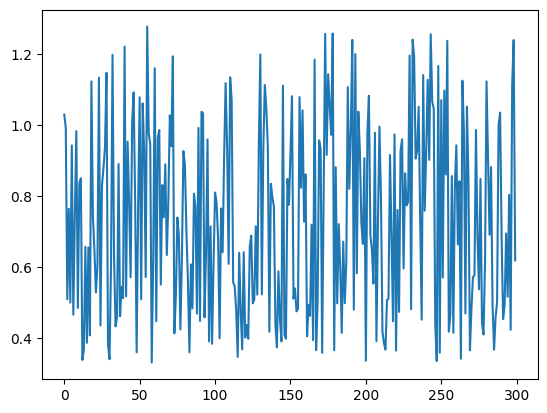

In [15]:
import matplotlib.pyplot as plt
from torch.optim import Adam

optimizer = Adam(img_encoder.parameters())
losses = []
for _ in range(3):
    permutation = np.random.permutation(len(data))
    for x, y in zip(data[permutation], targets[permutation]):
        optimizer.zero_grad()
        out = model(x.float().unsqueeze(0))
        loss = F.binary_cross_entropy_with_logits(out, y.float().view(1,1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

plt.plot(range(len(losses)), losses)

In [16]:
with torch.no_grad():
    predictions = torch.as_tensor([F.sigmoid(model(x.float().unsqueeze(0))) for x in data])
    print(binary_f1_score(predictions, targets))

tensor(0.4486)
